## Hierarchical Classification of Toxic Relational Dynamics

This notebook implements a hierarchical classification architecture to identify toxic relational dynamics from conversational data. 

#### Stage 1 — Generalist Model
A classifier is trained on broad, merged **"super-categories"** to identify the general theme of a conversation.

#### Stage 2 — Specialist Sub-Models
For each super-category containing multiple fine-grained classes, a specialized model is trained to distinguish the nuances within that specific group.

In [7]:
# =============================================================================
# Section 1: Setup and Library Imports
# =============================================================================
import pandas as pd
import numpy as np
import os
import json
import logging
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Dict

# Configure logging for clear execution tracking
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

#### Section 2: Data Loading and Preprocessing

First, we define a helper function, **`format_conversation`**, to process the raw dialogue data.  
This function transforms a list of conversational turns into a single formatted string, preserving the speaker context by labeling them as **[A]** and **[B]**.

In [8]:
# =============================================================================
# Section 2: Data Loading, Preprocessing, and Splitting
# =============================================================================

def format_conversation(dialogue_list: List[Dict[str, str]]) -> str:
    """Formats a dialogue list into a single string with [A] and [B] speakers."""
    formatted_texts = []
    speaker_map = {}
    for entry in dialogue_list:
        speaker_name = entry.get('speaker', 'Unknown')
        text = entry.get('text', '')
        if speaker_name not in speaker_map:
            speaker_map[speaker_name] = '[A]' if not speaker_map else '[B]'
        
        if speaker_name in speaker_map:
            placeholder = speaker_map[speaker_name]
            formatted_texts.append(f'{placeholder}: "{text}"')
            
    return "\\n".join(formatted_texts)

# --- Define constants for file paths and column names ---
DATA_DIR = '../data/processed/' 
TRAIN_FILE = "train.json"
VAL_FILE = "val.json"
TEST_FILE = "test.json"
TEXT_COLUMN = 'conversation'
TARGET_COLUMN = 'person_couple'

# Load, merge, and preprocess data
logging.info("Loading and processing raw datasets (train, val, test)...")
train_df_raw = pd.read_json(os.path.join(DATA_DIR, TRAIN_FILE))
val_df_raw = pd.read_json(os.path.join(DATA_DIR, VAL_FILE))
test_df_raw = pd.read_json(os.path.join(DATA_DIR, TEST_FILE))

full_df = pd.concat([train_df_raw, val_df_raw, test_df_raw], ignore_index=True)
full_df.drop_duplicates(subset='conversation_id', inplace=True, keep='first')
full_df[TEXT_COLUMN] = full_df['dialogue'].apply(format_conversation)
logging.info(f"Total unique samples loaded and processed: {len(full_df)}.")

# Perform a stratified split into training (80%) and test (20%) sets
full_train_df, test_df = train_test_split(
    full_df, test_size=0.20, random_state=42, stratify=full_df[TARGET_COLUMN]
)
logging.info(f"Data split into: {len(full_train_df)} training samples, {len(test_df)} test samples.")

2025-08-15 10:04:21,026 - INFO - Loading and processing raw datasets (train, val, test)...
2025-08-15 10:04:21,045 - INFO - Total unique samples loaded and processed: 1000.
2025-08-15 10:04:21,048 - INFO - Data split into: 800 training samples, 200 test samples.


### Section 3: Label Engineering — Creating Super-Categories

Based on the exploratory data analysis, several toxic relationship categories exhibit **high linguistic overlap**.  

To address this, we engineer a new target label, **`super_category`**, by merging similar classes into **broader, more distinct groups**.  

This new label will be used to train the **Stage 1 generalist model**.

In [9]:
# =============================================================================
# Section 3: Label Engineering (Super-Category Creation)
# =============================================================================
logging.info("Engineering super-category labels...")
super_category_map = {
    'Controllore e Isolata': 'Controlling Dynamics', 'Dominante e Schiavo emotivo': 'Controlling Dynamics',
    'Manipolatore e Dipendente emotiva': 'Controlling Dynamics', 'Persona violenta e Succube': 'Controlling Dynamics',
    'Narcisista e Succube': 'Antagonistic Dynamics', 'Psicopatico e Adulatrice': 'Antagonistic Dynamics',
    'Sadico-Crudele e Masochista': 'Antagonistic Dynamics',
    'Geloso-Ossessivo e Sottomessa': 'Geloso-Ossessivo e Sottomessa',
    'Perfezionista Critico e Insicura Cronica': 'Perfezionista Critico e Insicura Cronica',
    'Vittimista e Croccerossina': 'Vittimista e Croccerossina'
}
full_train_df['super_category'] = full_train_df[TARGET_COLUMN].map(super_category_map)
test_df['super_category'] = test_df[TARGET_COLUMN].map(super_category_map)

2025-08-15 10:04:21,054 - INFO - Engineering super-category labels...


### Section 4: Stage 1 — Generalist Model Training and Evaluation

In this stage, we **train and evaluate** the generalist model.  
Its task is to classify conversations into **one of the six broad super-categories**.

We use a **Pipeline** combining:

- **`TfidfVectorizer`**
- **`LogisticRegression`** classifier

The model is optimized with **`GridSearchCV`** to find the best hyperparameters.

Finally, the model's performance is evaluated on the **test set**.

In [10]:
# =============================================================================
# Section 4: STAGE 1 - Generalist Model Training and Evaluation
# =============================================================================
print("\n" + "="*60)
print(" STAGE 1: Training and Evaluating the Generalist Model")
print("="*60 + "\n")

pipeline_generalist = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 3), max_features=15000)),
    ('clf', LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced'))
])
parameters_generalist = {'tfidf__max_df': (0.5, 0.75), 'clf__C': (0.1, 1, 10)}

grid_generalist = GridSearchCV(pipeline_generalist, parameters_generalist, cv=5, n_jobs=-1, verbose=1)
grid_generalist.fit(full_train_df[TEXT_COLUMN], full_train_df['super_category'])
logging.info(f"Best parameters for generalist model: {grid_generalist.best_params_}")

y_true_general = test_df['super_category']
y_pred_general = grid_generalist.predict(test_df[TEXT_COLUMN])

print("\n--- Performance of the Generalist Model (on 6 super-categories) ---")
print(f"Accuracy: {accuracy_score(y_true_general, y_pred_general):.4f}")

print(f"Recall (Weighted Avg): {recall_score(y_true_general, y_pred_general, average='weighted'):.4f}")
print(f"F1-Score (Weighted Avg): {f1_score(y_true_general, y_pred_general, average='weighted'):.4f}")

print(classification_report(y_true_general, y_pred_general))


 STAGE 1: Training and Evaluating the Generalist Model

Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\Andrei\Desktop\universita\1-A-2-S\NLP\Progetto\CIPV_project\llm_env_py311\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
2025-08-15 10:04:22,554 - INFO - Best parameters for generalist model: {'clf__C': 1, 'tfidf__max_df': 0.5}



--- Performance of the Generalist Model (on 6 super-categories) ---
Accuracy: 0.7700
Recall (Weighted Avg): 0.7700
F1-Score (Weighted Avg): 0.7585
                                          precision    recall  f1-score   support

                   Antagonistic Dynamics       0.78      0.85      0.82        60
                    Controlling Dynamics       0.74      0.89      0.81        80
           Geloso-Ossessivo e Sottomessa       1.00      0.35      0.52        20
Perfezionista Critico e Insicura Cronica       0.71      0.60      0.65        20
              Vittimista e Croccerossina       0.87      0.65      0.74        20

                                accuracy                           0.77       200
                               macro avg       0.82      0.67      0.71       200
                            weighted avg       0.79      0.77      0.76       200



### Section 5: Stage 2 — Specialist Sub-Model Training and Evaluation

In this stage, we **train and evaluate** the specialist sub-models.  

Each specialist is trained **only** on the data belonging to its assigned **super-category** (e.g., *"Controlling Dynamics"*).  

Its goal is to perform the **fine-grained classification** within that specific subset.

We evaluate each specialist **independently** on the corresponding slice of the test data to assess its performance on its **specialized task**.


In [11]:
# =============================================================================
# Section 5: STAGE 2 - Specialist Sub-Models Training
# =============================================================================

print("\n" + "="*60)
print(" STAGE 2: Training the Specialist Sub-Models")
print("="*60 + "\n")

def train_specialist_model(super_cat_name, train_df):
    """A cleaner function to only train and return a specialist model."""
    logging.info(f"Training specialist model for '{super_cat_name}'...")
    
    train_specialist_df = train_df[train_df['super_category'] == super_cat_name]
    
    pipeline_specialist = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 3), max_features=7000)),
        ('clf', LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced'))
    ])
    parameters_specialist = {'tfidf__max_df': (0.5, 0.75), 'clf__C': (0.1, 1, 10)}
    
    grid_specialist = GridSearchCV(pipeline_specialist, parameters_specialist, cv=3, n_jobs=-1, verbose=1)
    grid_specialist.fit(train_specialist_df[TEXT_COLUMN], train_specialist_df[TARGET_COLUMN])
    
    logging.info(f"Finished training for '{super_cat_name}'. Best params: {grid_specialist.best_params_}")
    return grid_specialist.best_estimator_

# Train and store the specialist models
specialist_models = {}
specialist_models['Controlling Dynamics'] = train_specialist_model('Controlling Dynamics', full_train_df)
specialist_models['Antagonistic Dynamics'] = train_specialist_model('Antagonistic Dynamics', full_train_df)

2025-08-15 10:04:22,596 - INFO - Training specialist model for 'Controlling Dynamics'...



 STAGE 2: Training the Specialist Sub-Models

Fitting 3 folds for each of 6 candidates, totalling 18 fits


c:\Users\Andrei\Desktop\universita\1-A-2-S\NLP\Progetto\CIPV_project\llm_env_py311\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
2025-08-15 10:04:22,986 - INFO - Finished training for 'Controlling Dynamics'. Best params: {'clf__C': 10, 'tfidf__max_df': 0.5}
2025-08-15 10:04:22,987 - INFO - Training specialist model for 'Antagonistic Dynamics'...


Fitting 3 folds for each of 6 candidates, totalling 18 fits


c:\Users\Andrei\Desktop\universita\1-A-2-S\NLP\Progetto\CIPV_project\llm_env_py311\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
2025-08-15 10:04:23,227 - INFO - Finished training for 'Antagonistic Dynamics'. Best params: {'clf__C': 1, 'tfidf__max_df': 0.5}



 STAGE 2: Evaluating the Specialist Sub-Models

--- Evaluating Specialist: 'Controlling Dynamics' ---
Accuracy on its subset: 0.7750
Recall (Weighted Avg) on its subset: 0.7750
F1-Score (Weighted Avg) on its subset: 0.7767
                                   precision    recall  f1-score   support

            Controllore e Isolata       0.73      0.80      0.76        20
      Dominante e Schiavo emotivo       0.94      0.80      0.86        20
Manipolatore e Dipendente emotiva       0.73      0.80      0.76        20
       Persona violenta e Succube       0.74      0.70      0.72        20

                         accuracy                           0.78        80
                        macro avg       0.78      0.78      0.78        80
                     weighted avg       0.78      0.78      0.78        80



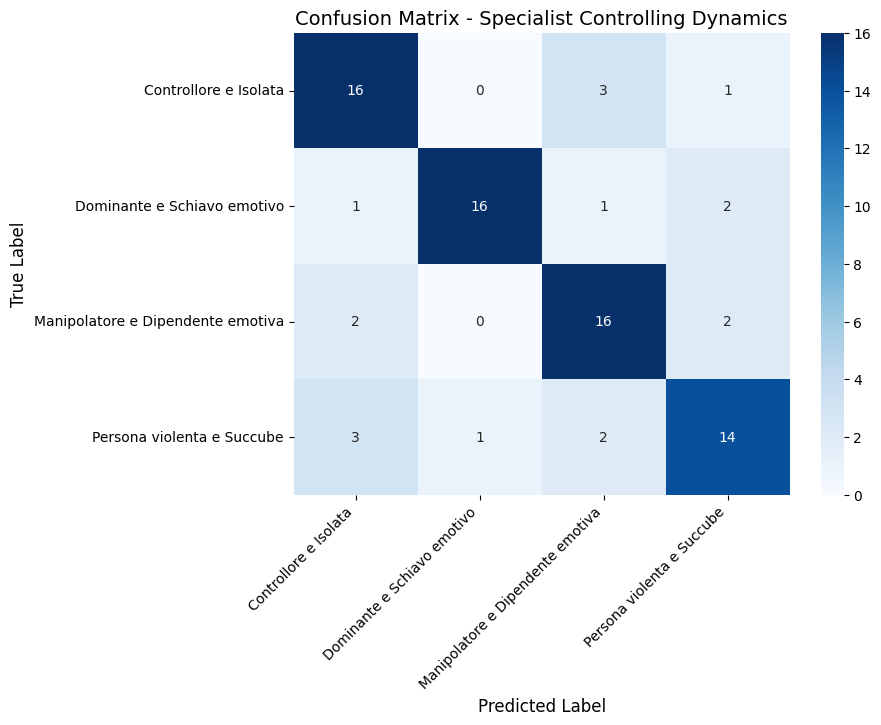

--- Evaluating Specialist: 'Antagonistic Dynamics' ---
Accuracy on its subset: 0.8333
Recall (Weighted Avg) on its subset: 0.8333
F1-Score (Weighted Avg) on its subset: 0.8341
                             precision    recall  f1-score   support

       Narcisista e Succube       0.76      0.80      0.78        20
   Psicopatico e Adulatrice       0.89      0.85      0.87        20
Sadico-Crudele e Masochista       0.85      0.85      0.85        20

                   accuracy                           0.83        60
                  macro avg       0.84      0.83      0.83        60
               weighted avg       0.84      0.83      0.83        60



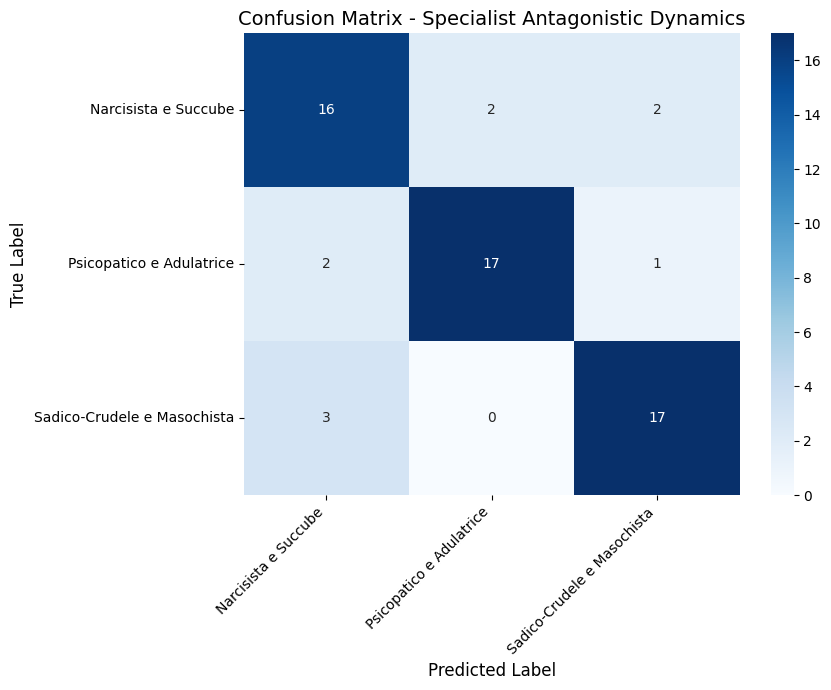

In [ ]:
# =============================================================================
# Section 6: STAGE 2 - Specialist Sub-Models Evaluation
# =============================================================================
print("\n" + "="*60)
print(" STAGE 2: Evaluating the Specialist Sub-Models")
print("="*60 + "\n")

for super_cat_name, model in specialist_models.items():
    print(f"--- Evaluating Specialist: '{super_cat_name}' ---")
    
    test_specialist_df = test_df[test_df['super_category'] == super_cat_name]
    
    if len(test_specialist_df) > 0:
        y_true_specialist = test_specialist_df[TARGET_COLUMN]
        y_pred_specialist = model.predict(test_specialist_df[TEXT_COLUMN])
        
        print(f"Accuracy on its subset: {accuracy_score(y_true_specialist, y_pred_specialist):.4f}")
        
        print(f"Recall (Weighted Avg) on its subset: {recall_score(y_true_specialist, y_pred_specialist, average='weighted'):.4f}")
        print(f"F1-Score (Weighted Avg) on its subset: {f1_score(y_true_specialist, y_pred_specialist, average='weighted'):.4f}")
      

        print(classification_report(y_true_specialist, y_pred_specialist, zero_division=0))
        
        plt.figure(figsize=(8, 6))
        class_names = sorted(y_true_specialist.unique())
        cm = confusion_matrix(y_true_specialist, y_pred_specialist, labels=class_names)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix - Specialist {super_cat_name}', fontsize=14)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.show()
    else:
        logging.warning(f"No test samples found for '{super_cat_name}' to evaluate.")


In [15]:
# =============================================================================
# Section 7: Final Model Performance Evaluation
# =============================================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import os
import logging

def run_final_evaluation(
    generalist_model,
    specialist_models_dict: dict,
    validation_file_path: str,
    text_column: str,
    target_column: str,
    format_conversation_func
):
    """
    Loads a validation dataset, performs an end-to-end hierarchical prediction.

    Args:
        generalist_model: The trained generalist classifier.
        specialist_models_dict (dict): A dictionary of trained specialist models,
                                      keyed by their super-category name.
        validation_file_path (str): The path to the .json validation file.
        text_column (str): The name of the column containing the conversation text.
        target_column (str): The name of the column containing the ground truth labels.
        format_conversation_func (function): The function used to format raw dialogue data.
    """
    print("\n" + "="*80)
    print(" STAGE 3: HIERARCHICAL MODEL - FINAL PERFORMANCE EVALUATION")
    print("="*80 + "\n")

    logging.info("Starting final performance evaluation protocol...")

    # --- 1. Load and Prepare Validation Data ---
    try:
        unseen_df = pd.read_json(validation_file_path)
        unseen_df[text_column] = unseen_df['dialogue'].apply(format_conversation_func)
        logging.info(f"Loaded {len(unseen_df)} samples from '{os.path.basename(validation_file_path)}' for final evaluation.")
    except FileNotFoundError:
        logging.error(f"FATAL: Validation file not found at path: {validation_file_path}")
        print(f"Error: Could not find the validation file at {validation_file_path}. Aborting evaluation.")
        return

    # --- 2. Hierarchical Prediction Logic ---
    def predict_single_conversation(text: str) -> str:
        """Executes a full hierarchical prediction on a single text sample."""
        super_category_pred = generalist_model.predict([text])[0]
        
        # If the predicted super-category has a dedicated specialist, use it
        if super_category_pred in specialist_models_dict:
            specialist_model = specialist_models_dict[super_category_pred]
            final_prediction = specialist_model.predict([text])[0]
            return final_prediction
        # Otherwise, the super-category prediction is the final prediction
        else:
            return super_category_pred

    # --- 3. Execute Predictions on the Validation Set ---
    logging.info("Executing predictions on the full validation set...")
    y_true = unseen_df[target_column].tolist()
    y_pred = [predict_single_conversation(text) for text in unseen_df[text_column]]
    logging.info("Prediction run completed successfully.")

    # --- 4. Calculate and Report Performance Metrics ---
    print("\n" + "="*80)
    print(" PERFORMANCE REPORT ON THE VALIDATION SET")
    print("="*80)

    # Overall Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"\nOverall Accuracy: {accuracy:.4f} ({accuracy:.2%})")
    print(f"Overall Recall (Weighted Avg): {recall:.4f} ({recall:.2%})")
    print(f"Overall F1-Score (Weighted Avg): {f1:.4f} ({f1:.2%})")
    print("-" * 80)

    print("\nClassification Report:\n")
    all_labels = sorted(list(set(y_true) | set(y_pred)))
    print(classification_report(y_true, y_pred, digits=4, labels=all_labels, zero_division=0))
    print("-" * 80)

    # --- 5. Generate and Display Confusion Matrix ---
    print("\nConfusion Matrix Visualization:")
    print("The matrix below illustrates class-level misclassifications.")
    
    fig, ax = plt.subplots(figsize=(12, 10))
    cm = confusion_matrix(y_true, y_pred, labels=all_labels)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=all_labels, yticklabels=all_labels, ax=ax)
    
    ax.set_title('Confusion Matrix on Validation Set', fontsize=16, pad=20)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=0)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)

2025-08-15 10:04:55,475 - INFO - Starting final performance evaluation protocol...
2025-08-15 10:04:55,480 - INFO - Loaded 150 samples from 'val.json' for final evaluation.
2025-08-15 10:04:55,480 - INFO - Executing predictions on the full validation set...
2025-08-15 10:04:55,576 - INFO - Prediction run completed successfully.


Found trained models. Initiating final evaluation...

 STAGE 3: HIERARCHICAL MODEL - FINAL PERFORMANCE EVALUATION


 PERFORMANCE REPORT ON THE VALIDATION SET

Overall Accuracy: 0.8933 (89.33%)
Overall Recall (Weighted Avg): 0.8933 (89.33%)
Overall F1-Score (Weighted Avg): 0.8927 (89.27%)
--------------------------------------------------------------------------------

Classification Report:

                                          precision    recall  f1-score   support

                   Controllore e Isolata     0.8889    0.9412    0.9143        17
             Dominante e Schiavo emotivo     0.8182    0.9000    0.8571        10
           Geloso-Ossessivo e Sottomessa     1.0000    0.7333    0.8462        15
       Manipolatore e Dipendente emotiva     0.8462    0.8462    0.8462        13
                    Narcisista e Succube     0.9333    1.0000    0.9655        14
Perfezionista Critico e Insicura Cronica     0.8571    0.8571    0.8571        21
              Persona violenta

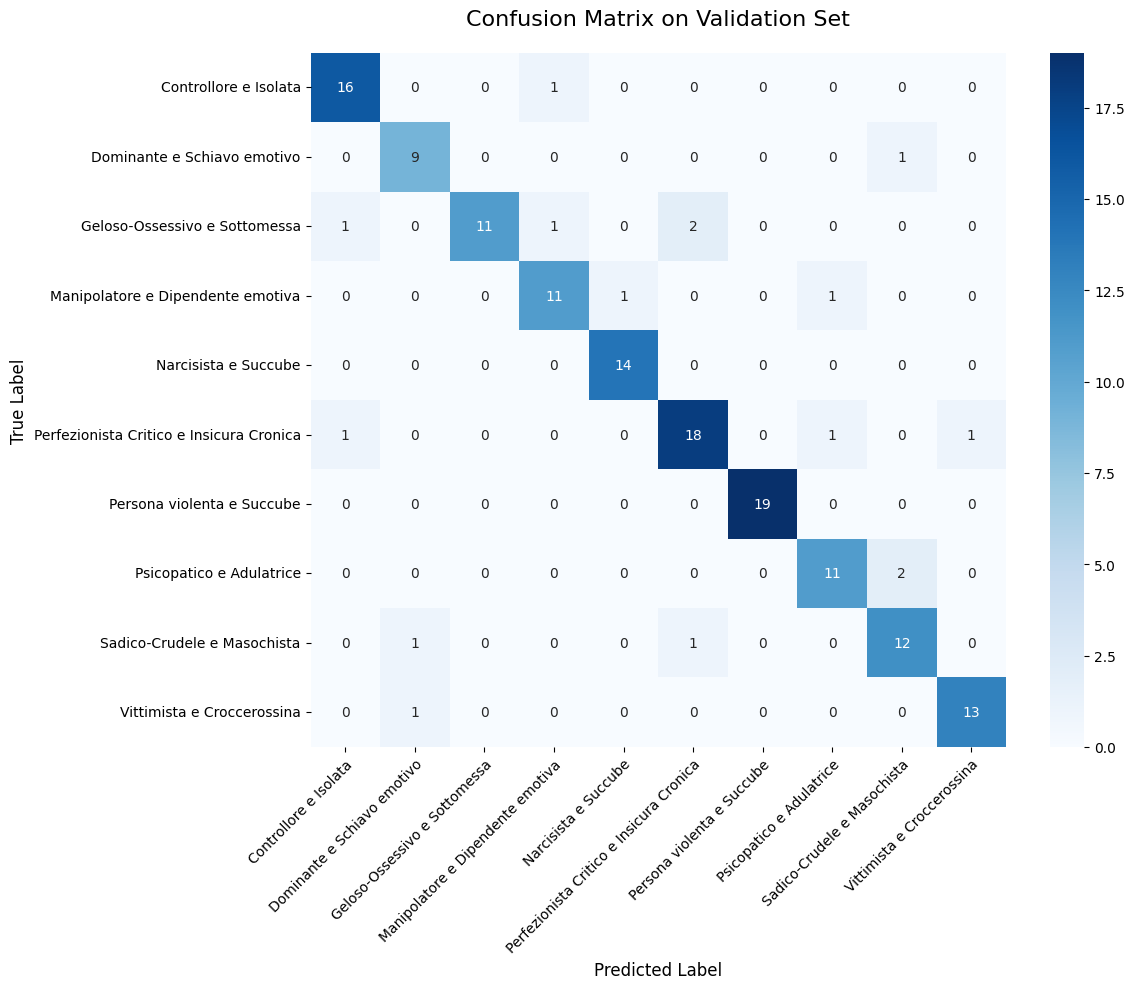

In [16]:
if 'grid_generalist' in locals() and 'specialist_models' in locals():
    print("Found trained models. Initiating final evaluation...")
    
    # Define variables for the function call
    final_generalist_model = grid_generalist.best_estimator_
    final_specialist_models = specialist_models
    validation_path = os.path.join(DATA_DIR, VAL_FILE)

    # Execute the evaluation function
    run_final_evaluation(
        generalist_model=final_generalist_model,
        specialist_models_dict=final_specialist_models,
        validation_file_path=validation_path,
        text_column=TEXT_COLUMN,
        target_column=TARGET_COLUMN,
        format_conversation_func=format_conversation
    )
else:
    error_message = "Could not find 'grid_generalist' or 'specialist_models'. Please ensure models are trained before running this cell."
    logging.error(error_message)
    print(f"Error: {error_message}")